<a href="https://colab.research.google.com/github/eshita1802/Continuous-Authentication/blob/main/Improved_tree_based_ensemble_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from sklearn.ensemble import GradientBoostingClassifier  # or use HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier  # Optional: uncomment to use
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import joblib
from scipy import signal
from tqdm import tqdm
import time

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Configuration
WINDOW_SIZE = 150  # 3 seconds at 50Hz
STEP_SIZE = 75      # 50% overlap
SENSORS = ['Ax', 'Ay', 'Az',
          'Gx', 'Gy', 'Gz']

def extract_enhanced_features(window):
    """Advanced feature extraction with time-frequency analysis"""
    features = []

    # Time-domain features
    for sensor in SENSORS:
        x = window[sensor].values
        features += [
            np.mean(x), np.std(x), np.min(x), np.max(x),
            np.percentile(x, 25), np.percentile(x, 75),
            np.median(x), np.mean(np.diff(x)),
            np.sqrt(np.mean(x**2)),  # RMS
            np.sum(x**2)             # Energy
        ]

    # Frequency-domain features
    for sensor in SENSORS[:3]:  # Accelerometer only
        nperseg = min(WINDOW_SIZE, len(x))  # Ensure nperseg <= signal length
        f, Pxx = signal.welch(window[sensor], fs=50, nperseg=nperseg)
        features += [
            np.sum(Pxx[:5]),    # Low-frequency power
            np.sum(Pxx[5:10]),  # Mid-frequency power
            np.sum(Pxx[10:])    # High-frequency power
        ]

    # Cross-sensor correlations
    accel = window[['Ax', 'Ay', 'Az']].values
    features += [
        np.corrcoef(accel[:,0], accel[:,1])[0,1],
        np.corrcoef(accel[:,0], accel[:,2])[0,1],
        np.corrcoef(accel[:,1], accel[:,2])[0,1]
    ]

    return np.array(features)

def load_and_process_data(folder_path):
    """Load all Excel files with enhanced processing"""
    all_files = glob(os.path.join(folder_path, "*.xlsx"))
    features = []
    labels = []

    for file_path in tqdm(all_files, desc="Processing files"):
        df = pd.read_excel(file_path)
        df = df[['participant_id'] + SENSORS].apply(pd.to_numeric, errors='coerce')
        df.dropna(inplace=True)

        # Create overlapping windows
        for i in range(0, len(df)-WINDOW_SIZE, STEP_SIZE):
            window = df.iloc[i:i+WINDOW_SIZE]
            features.append(extract_enhanced_features(window))
            labels.append(window['participant_id'].mode()[0])

    return np.array(features), np.array(labels)

# Main Pipeline

# 1. Load and process data
X, y = load_and_process_data("/content/drive/MyDrive/Dataset")
print(f"Full dataset shape: {X.shape}")







Mounted at /content/drive


Processing files: 100%|██████████| 32/32 [1:25:35<00:00, 160.47s/it]


Full dataset shape: (268736, 72)


In [ ]:
#X, y = X[:50000], y[:50000]

# 2. Feature selection
selector = SelectKBest(mutual_info_classif, k=30)
X_selected = selector.fit_transform(X, y)

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, stratify=y, random_state=42
)

Starting grid search...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Grid search completed in 1.98 minutes

Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 100}

Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.80      0.83      5376
           2       0.90      0.90      0.90      5376
           3       0.83      0.89      0.86      5376
           4       0.86      0.86      0.86      5376
           5       0.76      0.80      0.78      5376
           6       0.87      0.87      0.87      5376
           7       0.85      0.84      0.85      5376
           8       0.92      0.85      0.89      5376
           9       0.87      0.86      0.87      5376
          10       0.80      0.83      0.82      5364

    accuracy                           0.85     53748
   macro avg       0.85      0.85      0.85     53748
weighted avg       0.85      0.85      0.85     53748



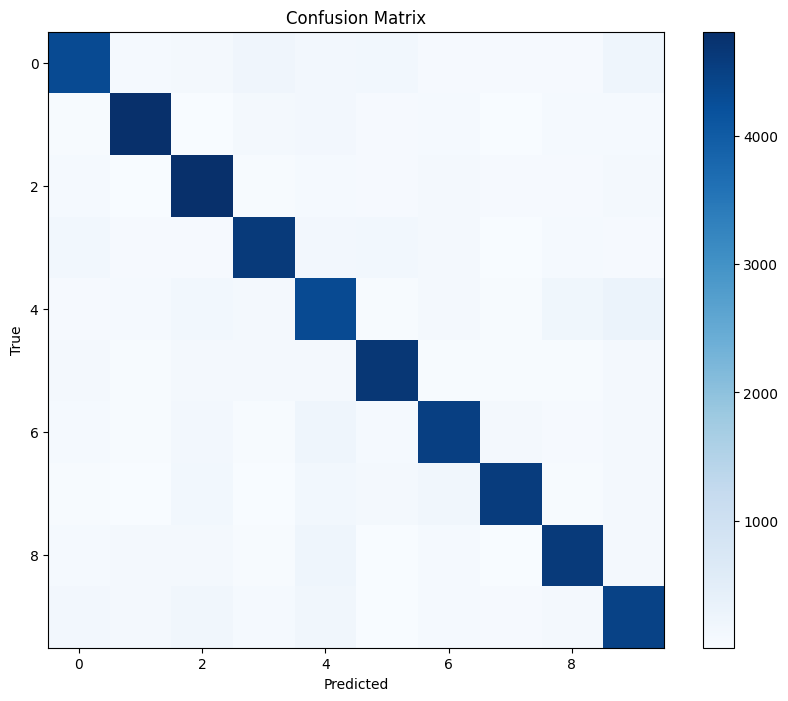


Model and selector saved successfully
Computing permutation importances...


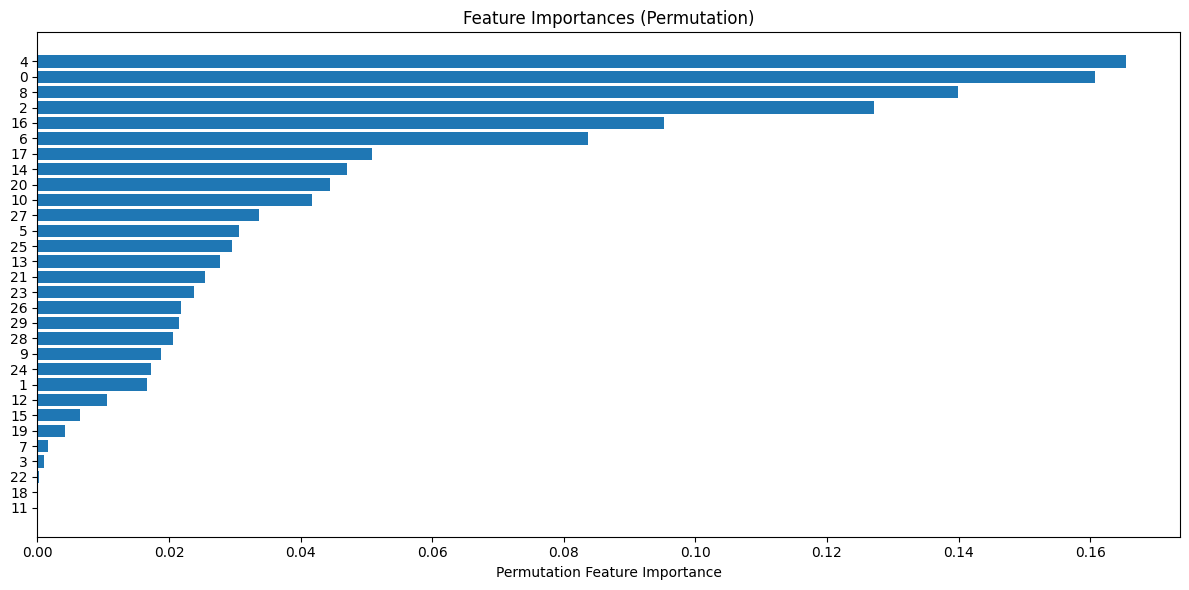

In [ ]:
# 4. Model tuning (simplified grid)
param_grid = {
        'max_iter': [100],
        'learning_rate': [0.1],
        'max_depth': [3]
}

print("Starting grid search...")
start = time.time()
gb = GradientBoostingClassifier(random_state=42)
gb = HistGradientBoostingClassifier(random_state=42)  # Optional alternative
grid_search = GridSearchCV(gb, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
print(f"Grid search completed in {(time.time() - start) / 60:.2f} minutes")

best_model = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")

# Save grid search results
joblib.dump(grid_search, "grid_search_result.pkl")

# 5. Evaluation
y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 6. Save model
joblib.dump(best_model, "optimized_auth_model.pkl")
joblib.dump(selector, "feature_selector.pkl")
print("\nModel and selector saved successfully")

# 7. Feature Importance
from sklearn.inspection import permutation_importance

# Compute permutation importance
print("Computing permutation importances...")
r = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Sort features by importance
sorted_idx = r.importances_mean.argsort()

# Plot
plt.figure(figsize=(12,6))
plt.barh(range(len(sorted_idx)), r.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), sorted_idx)
plt.xlabel("Permutation Feature Importance")
plt.title("Feature Importances (Permutation)")
plt.tight_layout()
plt.show()
